# IMDB - Word2Vec with LSTM
> ## NLP(Natural Language Processing)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Tensorflow

In [2]:
import tensorflow

tensorflow.__version__

'2.5.0'

# I. IMDB Data_Set

> ## 1) Load IMDB Data_Set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/IMDB.zip 

-rw------- 1 root root 60711700 Mar 21 01:09 '/content/drive/My Drive/Colab Notebooks/datasets/IMDB.zip'


In [5]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/IMDB.zip 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: __MACOSX/aclImdb/train/pos/._7754_9.txt  
  inflating: aclImdb/train/pos/7755_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7755_9.txt  
  inflating: aclImdb/train/pos/7756_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7756_10.txt  
  inflating: aclImdb/train/pos/7757_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7757_9.txt  
  inflating: aclImdb/train/pos/7758_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7758_7.txt  
  inflating: aclImdb/train/pos/7759_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7759_10.txt  
  inflating: aclImdb/train/pos/775_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._775_7.txt  
  inflating: aclImdb/train/pos/7760_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7760_10.txt  
  inflating: aclImdb/train/pos/7761_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7761_10.txt  
  inflating: aclImdb/train/pos/7762_8.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7762_8.txt  
  inflating:

> ## 2) 'texts' and 'labels' Data

* 'texts'  : 문자열 리스트(영화 감상평)
* 'lebels' : 감상평 리뷰(긍정/부정)

In [6]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [7]:
len(labels), len(texts)

(25000, 25000)

# II. Tensor Transformation

> ## 1) X_train and X_valid : (25000, 2000)

* vectorization
 - (25000, 2000)

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 2000               # 2000개 단어까지 적용
max_words = 10000           # 빈도 높은 10000개 단어 사용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

# (25000, 2000)으로 패딩
data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)


# 샘플 데이터 랜덤화
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


# 데이터를 훈련 세트와 검증 세트로 분할
training_samples = 15000            # 훈련 샘플은 15000개
validation_samples = 10000          # 검증 샘플은 10000개

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 2000)
레이블 텐서의 크기: (25000,)


# III. Word2Vec

https://tfhub.dev/google/Wiki-words-250-with-normalization/2

> ## 1) Load Pretrained Word2Vec

In [9]:
import tensorflow_hub as hub

embeddings_index = hub.load('https://tfhub.dev/google/Wiki-words-250/2')

* Word2Vec 매핑 확인

In [10]:
embeddings_index(['apple'])

<tf.Tensor: shape=(1, 250), dtype=float32, numpy=
array([[-7.81319588e-02, -7.97718316e-02,  1.65636316e-02,
        -1.08001232e-02, -5.10360440e-03,  1.73767412e-03,
        -5.22104278e-02, -3.89753021e-02,  3.56903672e-02,
        -3.47909741e-02, -1.01491222e-02,  1.17565657e-03,
         1.01802059e-01,  1.75360963e-02,  3.36469710e-02,
         2.79656947e-02,  9.57141817e-02, -7.82085657e-02,
         5.06314561e-02, -1.66016668e-01,  2.88206208e-02,
         6.76635057e-02,  9.70917642e-02,  1.79236010e-02,
        -5.42766303e-02, -1.56506345e-01, -5.30809052e-02,
        -1.09254161e-03, -1.59554277e-02, -6.70691356e-02,
         6.15172908e-02,  4.47090678e-02,  4.07696068e-02,
        -3.83969024e-02,  6.96176291e-02, -5.60147781e-03,
        -2.26747449e-02, -3.67878452e-02, -5.66431917e-02,
        -2.18681507e-02, -8.86453837e-02, -2.22746611e-01,
        -2.07957737e-02,  8.30694276e-04, -3.93166617e-02,
         5.93367852e-02,  4.33623493e-02,  2.82799695e-02,
      

> ## 2) 임베딩 행렬 생성

* (10000, 250)

In [11]:
embedding_dim = 250

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index([word])
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됨
            embedding_matrix[i] = embedding_vector

* 확인

In [12]:
embedding_matrix.shape

(10000, 250)

# IV. Keras Embedding Modeling

> ## 1) Model Define

* 모델 신경망 구조 정의
 - Embedding Dimension : 250

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

imdb = models.Sequential()

imdb.add(layers.Embedding(max_words,
                          embedding_dim,
                          input_length = maxlen))

imdb.add(layers.LSTM(16))
imdb.add(layers.Dropout(0.5))
imdb.add(layers.Dense(1, activation = 'sigmoid'))

In [14]:
imdb.layers[0].set_weights([embedding_matrix])
imdb.layers[0].trainable = False

* 모델 구조 확인

In [15]:
imdb.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 250)         2500000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                17088     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 2,517,105
Trainable params: 17,105
Non-trainable params: 2,500,000
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정

In [16]:
imdb.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

> ## 3) Model Fit

* 약 25분

In [17]:
%%time

Hist_imdb = imdb.fit(X_train, y_train,
                     epochs = 100,
                     batch_size = 512,
                     validation_data = (X_valid, y_valid))

Epoch 1/100
30/30 [==============================] - 22s 450ms/step - loss: 0.6891 - accuracy: 0.5385 - val_loss: 0.6822 - val_accuracy: 0.5898
Epoch 2/100
30/30 [==============================] - 13s 429ms/step - loss: 0.6606 - accuracy: 0.6164 - val_loss: 0.6297 - val_accuracy: 0.6713
Epoch 3/100
30/30 [==============================] - 13s 428ms/step - loss: 0.6078 - accuracy: 0.6967 - val_loss: 0.5763 - val_accuracy: 0.7193
Epoch 4/100
30/30 [==============================] - 13s 432ms/step - loss: 0.5838 - accuracy: 0.7095 - val_loss: 0.5513 - val_accuracy: 0.7427
Epoch 5/100
30/30 [==============================] - 13s 436ms/step - loss: 0.5444 - accuracy: 0.7518 - val_loss: 0.5091 - val_accuracy: 0.7610
Epoch 6/100
30/30 [==============================] - 13s 436ms/step - loss: 0.5252 - accuracy: 0.7585 - val_loss: 0.5340 - val_accuracy: 0.7388
Epoch 7/100
30/30 [==============================] - 13s 432ms/step - loss: 0.5179 - accuracy: 0.7618 - val_loss: 0.5224 - val_accuracy:

> ## 4) 학습 결과 시각화

* Loss Visualization

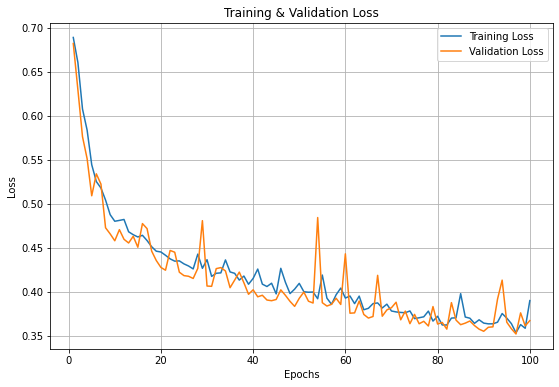

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_imdb.history['loss'])
plt.plot(epochs, Hist_imdb.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

* Accuracy Visualization

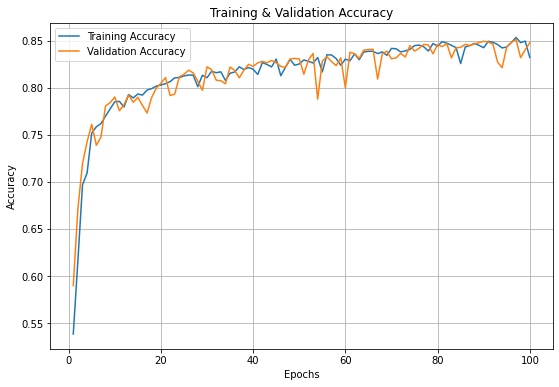

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['accuracy']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_imdb.history['accuracy'])
plt.plot(epochs, Hist_imdb.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

* Loss & Accuracy

In [20]:
loss, accuracy = imdb.evaluate(X_valid, y_valid)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

313/313 [==============================] - 11s 36ms/step - loss: 0.3671 - accuracy: 0.8476
Loss = 0.36713
Accuracy = 0.84760


# 
# 
# 
# The End
# 
# 
# 